References:
- https://github.com/yz93/LAVT-RIS
- https://openaccess.thecvf.com/content/CVPR2022/papers/Yang_LAVT_Language-Aware_Vision_Transformer_for_Referring_Image_Segmentation_CVPR_2022_paper.pdf

In [1]:
!git clone https://github.com/yz93/LAVT-RIS.git

Cloning into 'LAVT-RIS'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 131 (delta 15), reused 12 (delta 12), pack-reused 107 (from 1)
Receiving objects: 100% (131/131), 6.92 MiB | 25.20 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
%cd LAVT-RIS

/kaggle/working/LAVT-RIS


In [3]:
!pip install h5py timm mmcv==1.3.12 mmsegmentation==0.17.0 -q
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 6.2 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.2/542.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 13.6 MB/s e

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt

from bert.modeling_bert import BertModel
from bert.tokenization_bert import BertTokenizer
from lib import segmentation

In [5]:
device = 'cuda:0'
weights = '/kaggle/input/cse344-a3/refcoco.pth'

images = []
base = "/kaggle/input/cse344-a3/samples"

with open("/kaggle/input/cse344-a3/reference.txt", 'r') as file:
    for line in file:
        line = line.strip()
        parts = line.split(" : ")
        name = parts[0].strip()
        reference = parts[1].strip().strip('"')
        images.append({"name":name, "path":os.path.join(base,name), "reference":reference})

In [6]:
#citation: code adapted from github repo mentioned in the assignment (link- https://github.com/yz93/LAVT-RIS/blob/main/demo_inference.py)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#mini args class
class args:
    swin_type = 'base'
    window12 = True
    mha = ''
    fusion_drop = 0.0

single_model = segmentation.__dict__['lavt'](pretrained='', args=args)
single_bert_model = BertModel.from_pretrained('bert-base-uncased')
single_bert_model.pooler = None

checkpoint = torch.load(weights, map_location='cpu')
single_bert_model.load_state_dict(checkpoint['bert_model'])
single_model.load_state_dict(checkpoint['model'])
model = single_model.to(device)
bert_model = single_bert_model.to(device)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Window size 12!


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Randomly initialize Multi-modal Swin Transformer weights.


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

/kaggle/working/LAVT-RIS/bert/modeling_utils.py:676: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map_location="cpu")
/tmp/ip

In [7]:
#add a hook in the SimpleDecoding block to get y1 features
global_hook_dict = {}
def hook_fn(module, input, output):
    y1_np = output.detach().squeeze(0).mean(dim=0).cpu().numpy() #taking average of all feature maps
    y1_np -= y1_np.min()
    y1_np /= y1_np.max()
    y1_np *= 255.0
    y1_np = y1_np.astype(np.uint8)
    global_hook_dict["y1"] = y1_np
hook_handle = model.classifier.conv1_2.register_forward_hook(hook_fn)

In [8]:
#citation: code adapted from github repo mentioned in the assignment (link- https://github.com/yz93/LAVT-RIS/blob/main/demo_inference.py)

def overlay_mask(image, mask, colors=[[0, 0, 0], [255, 0, 0]], cscale=1, alpha=0.4):
    colors = np.reshape(colors, (-1, 3))
    colors = np.atleast_2d(colors) * cscale
    im_overlay = image.copy()
    object_ids = np.unique(mask)
    for object_id in object_ids[1:]:
        foreground = image * alpha + np.ones(image.shape) * (1 - alpha) * np.array(colors[object_id])
        binary_mask = mask == object_id
        im_overlay[binary_mask] = foreground[binary_mask]
        countours = binary_dilation(binary_mask) ^ binary_mask
        im_overlay[countours, :] = 0
    return im_overlay.astype(image.dtype)

def perform_inference(img_tensor, padded_sent_toks, attention_mask, model, bert_model, original_h, original_w):
    with torch.no_grad():
        last_hidden_states = bert_model(padded_sent_toks, attention_mask=attention_mask)[0]
        embedding = last_hidden_states.permute(0, 2, 1)
        output = model(img_tensor, embedding, l_mask=attention_mask.unsqueeze(-1))
        output = output.argmax(1, keepdim=True)
        output = F.interpolate(output.float(), (original_h, original_w), mode='nearest')
        output = output.squeeze().cpu().numpy().astype(np.uint8)
    return output

def preprocess_text(sentence, tokenizer, max_length=20, device='cuda:0'):
    sentence_tokenized = tokenizer.encode(text=sentence, add_special_tokens=True)
    sentence_tokenized = sentence_tokenized[:max_length] #truncate if longer than max_length
    #pad if shorter than max_length
    padded_sent_toks = [0] * max_length
    padded_sent_toks[:len(sentence_tokenized)] = sentence_tokenized
    #sentence token mask: 1 for real words; 0 for padded tokens
    attention_mask = [0] * max_length
    attention_mask[:len(sentence_tokenized)] = [1] * len(sentence_tokenized)
    #convert lists to tensors
    padded_sent_toks = torch.tensor(padded_sent_toks).unsqueeze(0).to(device)
    attention_mask = torch.tensor(attention_mask).unsqueeze(0).to(device)
    return padded_sent_toks, attention_mask

def preprocess_image(image_path, device='cuda:0'):
    img = Image.open(image_path).convert("RGB")
    original_w, original_h = img.size
    image_transforms = T.Compose([
        T.Resize(480),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = image_transforms(img).unsqueeze(0).to(device)
    return img_tensor, original_w, original_h, np.array(img)

def find_results(image_path, sentence, model, tokenizer, bert_model, device='cuda:0'):
    img_tensor, original_w, original_h, img_ndarray = preprocess_image(image_path, device)
    padded_sent_toks, attention_mask = preprocess_text(sentence, tokenizer, 20, device)
    output_mask = perform_inference(img_tensor, padded_sent_toks, attention_mask, model, bert_model, original_h, original_w)
    visualization = overlay_mask(img_ndarray, output_mask)
    return visualization

def plot_grid(images, image_key, title_key):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 12))
    axes = axes.flatten()
    for i in range(10): #len(images) is 10
        ax = axes[i]
        img = images[i][image_key]
        title = images[i][title_key]
        if img.ndim == 2:
            ax.imshow(img, cmap='seismic') #y1 features
        else:
            ax.imshow(img) #rgb image
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [87]:
for img_dict in images:
    visualization = find_results(img_dict["path"], img_dict["reference"], model, tokenizer, bert_model, device)
    img_dict["output"] = visualization
    img_dict["y1"] = global_hook_dict["y1"]

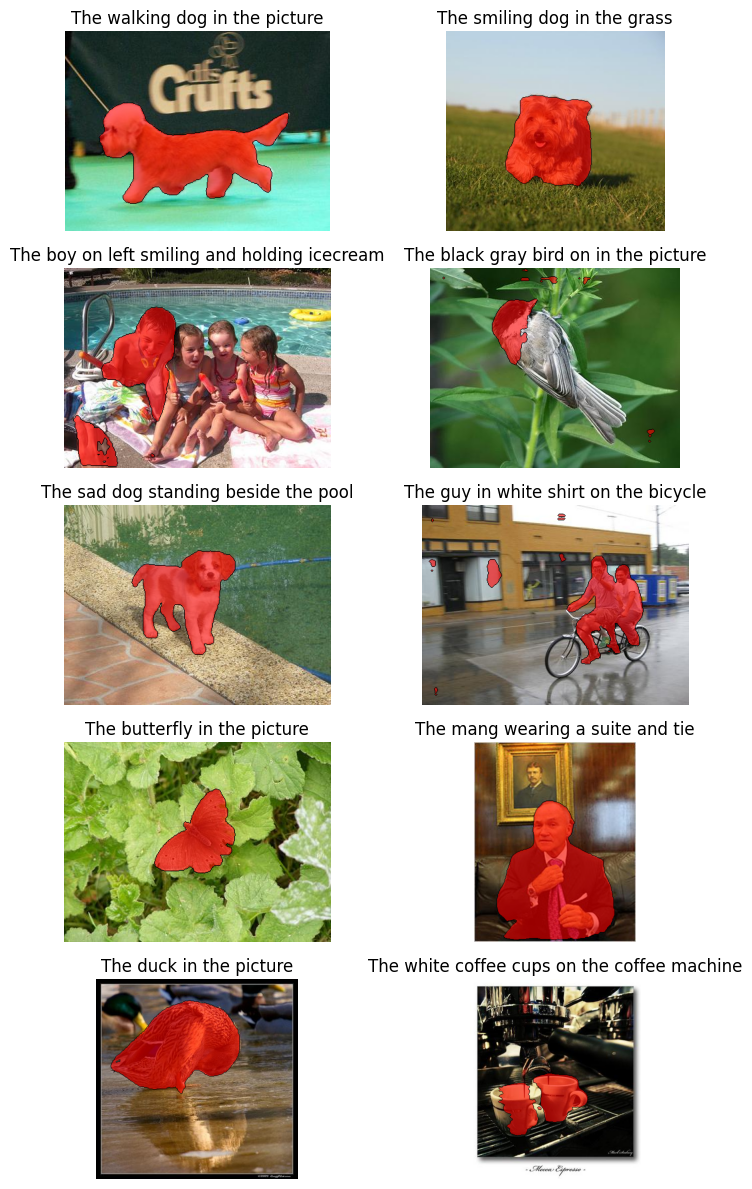

In [100]:
plot_grid(images, "output", "reference")

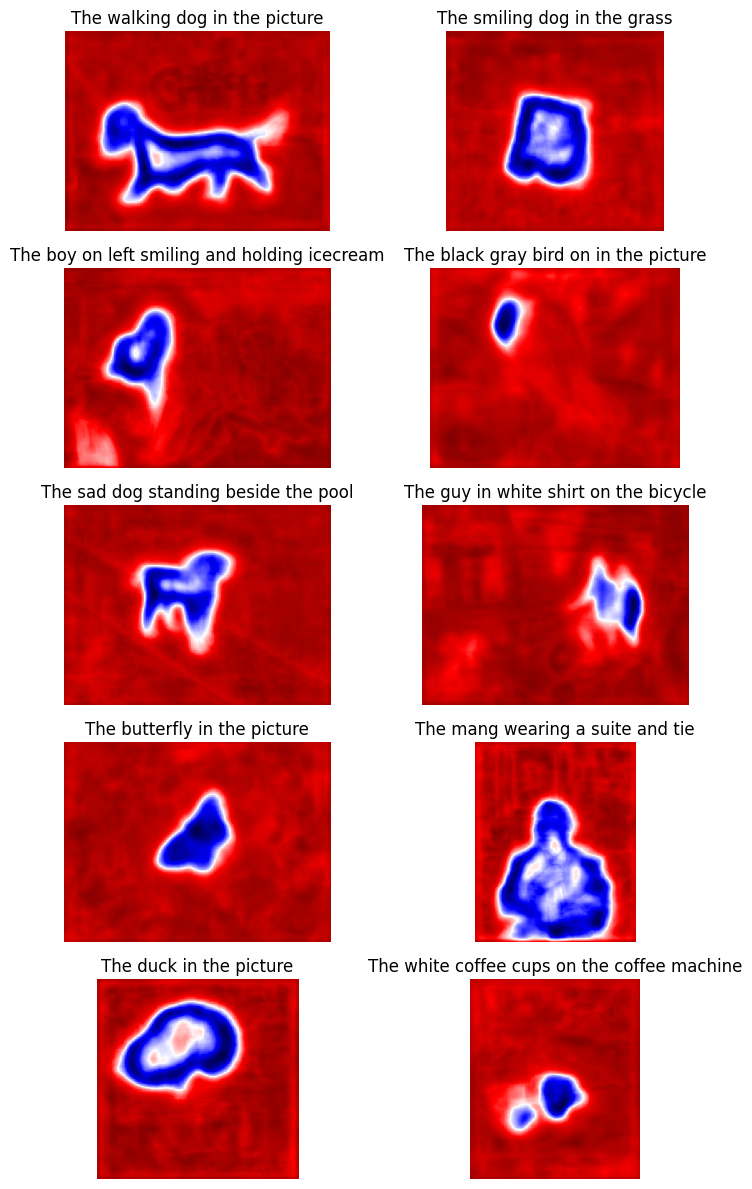

In [101]:
plot_grid(images, "y1", "reference")

In [18]:
ref_dict = {
    "ILSVRC2012_test_00000003.jpg": "The dog on the mat",
    "ILSVRC2012_test_00000004.jpg": "The dog on the grass",
    "ILSVRC2012_test_00000018.jpg": "The third girl from left",
    "ILSVRC2012_test_00000019.jpg": "The gray bird in the picture",
    "ILSVRC2012_test_00000022.jpg": "The dog beside the pool",
    "ILSVRC2012_test_00000023.jpg": "The bicycle in the picture",
    "ILSVRC2012_test_00000025.jpg": "The butterfly on the leaf",
    "ILSVRC2012_test_00000026.jpg": "The picture on the wall",
    "ILSVRC2012_test_00000030.jpg": "The reflection of duck",
    "ILSVRC2012_test_00000034.jpg": "The coffee machine in the picture"
}

for img_dict in images:
    img_dict['new_ref'] = ref_dict.get(img_dict['name'])

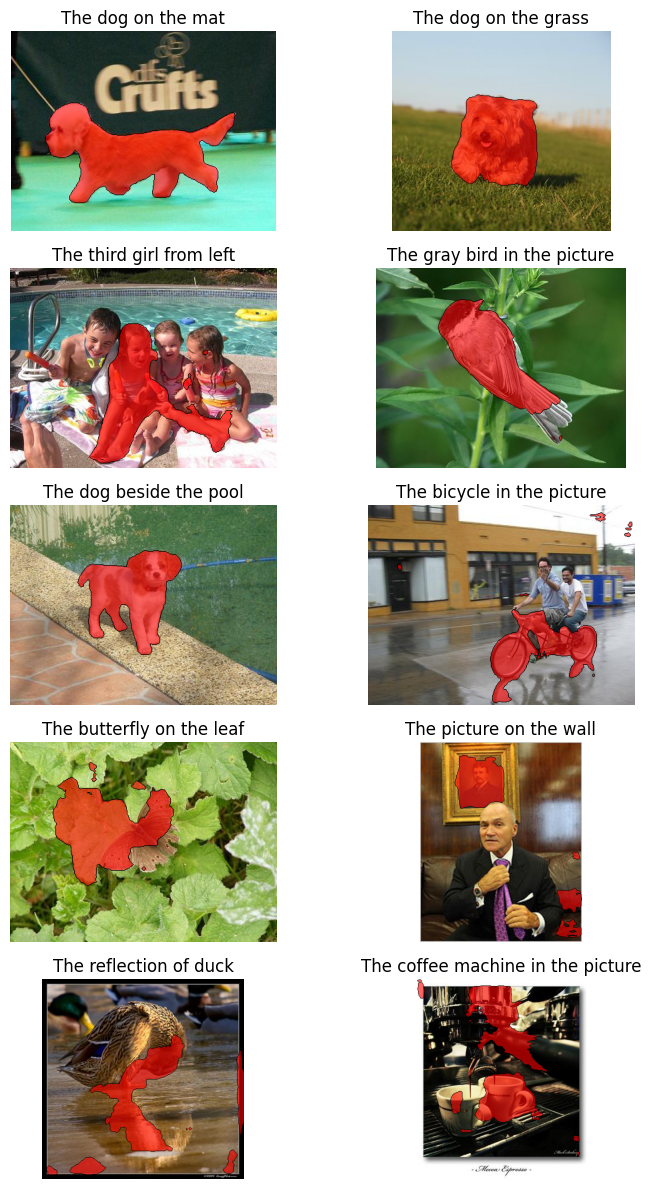

In [19]:
for img_dict in images:
    visualization = find_results(img_dict["path"], img_dict["new_ref"], model, tokenizer, bert_model, device)
    img_dict["new_output"] = visualization
plot_grid(images, "new_output", "new_ref")